In [1]:
#Imports
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
import os
import glob
import pandas as pd
import xarray as xr
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth
import cartopy.util as cutil
import logging
import utilities.funciones
import os, fnmatch
import utilities.sst_analysis 
import utilities.sst_EOF
from scipy import signal 

## Open dataset
path_sst = '/home/julia.mindlin/Kaplan_SST'
path_out = '/home/julia.mindlin/Tesis/Capitulo3/scripts/YESS_ML_Learning_group'
ssts = xr.open_dataset(path_sst+'/sst.mon.anom_remap.nc')
ssts.fillna(0)


<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 1984)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * time     (time) datetime64[ns] 1856-01-01 1856-02-01 ... 2021-04-01
Data variables:
    sst      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:            Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history:        Wed Sep 08 15:37:19 2021: cdo remapbil,n32 sst.mon.anom.n...
    Conventions:    COARDS
    title:          Kaplan Extended SST V2
    platform:       Analysis
    dataset_title:  Kaplan Extended V2 SST anomaly data
    description:    Data is processed at Lamont-Doherty using an \noptimal an...
    References:     https://www.psl.noaa.gov/data/gridded/data.kaplan_sst.html
    CDO:            Climate Data Operators version 1.7.2 (http://mpimet.mpg.d...

In [4]:
import utilities.regresion_pcs as reg_pc
import utilities.csv2nc

#reg = reg_pc.EOF_regression()

#reg.regression_data_obs('kaplan',ssts,[15,-15,150,280],[ssts.time[0],ssts.time[-1]],'None')

year_ini = np.datetime_as_string(ssts.time[0].values)[0:4]
year_fin = np.datetime_as_string(ssts.time[-1].values)[0:4]

file_name = year_ini+'_'+year_fin

pc_hist = pd.read_csv('/home/julia.mindlin/Tesis/Capitulo3/scripts/YESS_ML_Learning_group/principal_components/'+reg.model+'_pcs_'+file_name+'_ANNUAL_detrended.csv')



SyntaxError: invalid syntax (regresion_pcs.py, line 56)

In [9]:

file_name = year_ini+'_'+year_fin+'_C_E_index'

pc_hist = pd.read_csv('/home/julia.mindlin/Tesis/Capitulo3/scripts/YESS_ML_Learning_group/principal_components/kaplan_pcs_1856_2021_ANNUAL_detrended.csv')


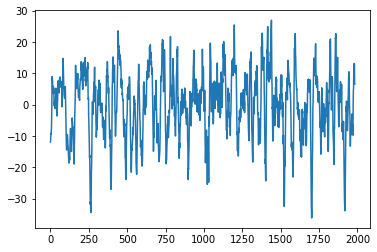

In [13]:
plt.plot(pc_hist['pc1'])
#plt.plot(pc_hist['pc2'])

In [28]:
#C_E_index = pd.DataFrame({'E_index':(pc_hist['pc1']-pc_hist['pc2'])/np.sqrt(2),'C_index':(pc_hist['pc1']+pc_hist['pc2'])/np.sqrt(2)})
#reg.perform_regression_obs(pc_hist,path_out,1,time_out,C_E_index)
#borrar esto
pc_hist = pd.DataFrame({'pc1':(pc_hist['pc1']-pc_hist['pc2'])/np.sqrt(2),'pc2':(pc_hist['pc1']+pc_hist['pc2'])/np.sqrt(2)})
reg.perform_regression_obs(pc_hist,path_out,1,time_out)

In [34]:
def plot_one_sst(sst,title,lons,lats,box,levels=np.arange(-.8,.8,0.1),cmap = 'RdBu_r'):

    fig = plt.figure(figsize=(10, 10),dpi=300,constrained_layout=True)
    data_crs = ccrs.PlateCarree()
    proj = ccrs.PlateCarree(central_longitude=180)
    ax1 = plt.subplot(1,1,1,projection=proj)
    im1=ax1.contourf(lons, lats, sst,levels,transform=data_crs,cmap=cmap,extend='both')
    ax1.set_title(utilities.funciones.split_title_line(title, max_words=5),fontsize=14)
    ax1.add_feature(cartopy.feature.COASTLINE,alpha=.5)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax1.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
    ax1.set_extent([-60, 120, -20, 20], ccrs.PlateCarree(central_longitude=180))
    ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())

    x_start, x_end, y_start, y_end = box[0],box[1],box[2],box[3]
    margin = 0.07
    margin_fractions = np.array([margin, 1.0 - margin])
    x_lower, x_upper = x_start + (x_end - x_start)*margin_fractions
    y_lower, y_upper = y_start + (y_end - y_start)*margin_fractions
    box_x_points = x_lower + (x_upper - x_lower)* np.array([0, 1, 1, 0, 0,])
    box_y_points = y_lower + (y_upper - y_lower)* np.array([0, 0, 1, 1, 0,])
    ax1.plot(box_x_points, box_y_points, transform=ccrs.PlateCarree(),linewidth=1.5, color='black',linestyle='-')

    plt1_ax = plt.gca()
    left, bottom, width, height = plt1_ax.get_position().bounds
    colorbar_axes = fig.add_axes([left + 0.9, bottom,0.02, height])
    cbar = fig.colorbar(im1, colorbar_axes, orientation='vertical')
    cbar.set_label(r'reg_coeff',fontsize=14) #rotation= radianes
    cbar.ax.tick_params(axis='both',labelsize=14)

    return fig


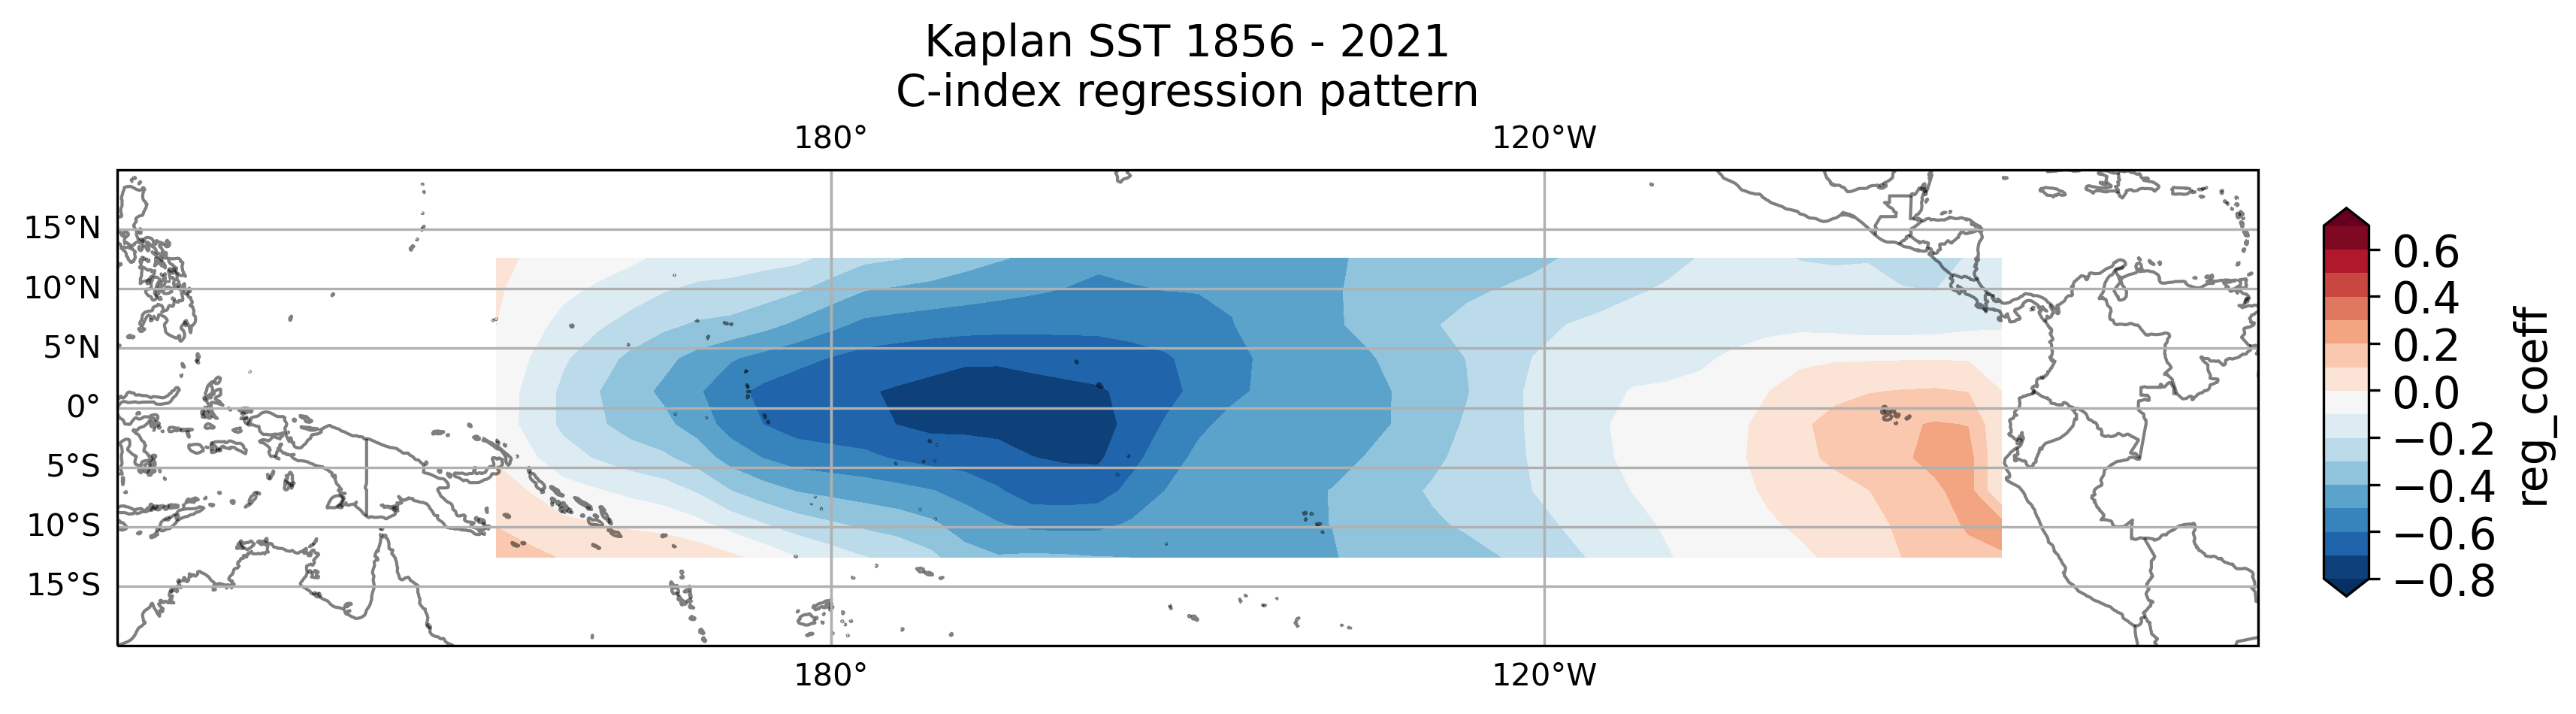

In [37]:
patterns = xr.open_dataset('/home/julia.mindlin/Tesis/Capitulo3/scripts/YESS_ML_Learning_group/eof_patterns/kaplan_PC_regression_pattern_'+time_out+'_detrended.nc')
fig = plot_one_sst(patterns.eof1,' Kaplan SST 1856 - 2021 C-index regression pattern',patterns.eof2.lon,patterns.eof2.lat,[5,-5,180,220])

In [39]:
path_out

'/home/julia.mindlin/Tesis/Capitulo3/scripts/YESS_ML_Learning_group'

In [45]:
fig.savefig(path_out+'/plots/kaplan_'+time_out+'_C_index_regression_patterns.png')

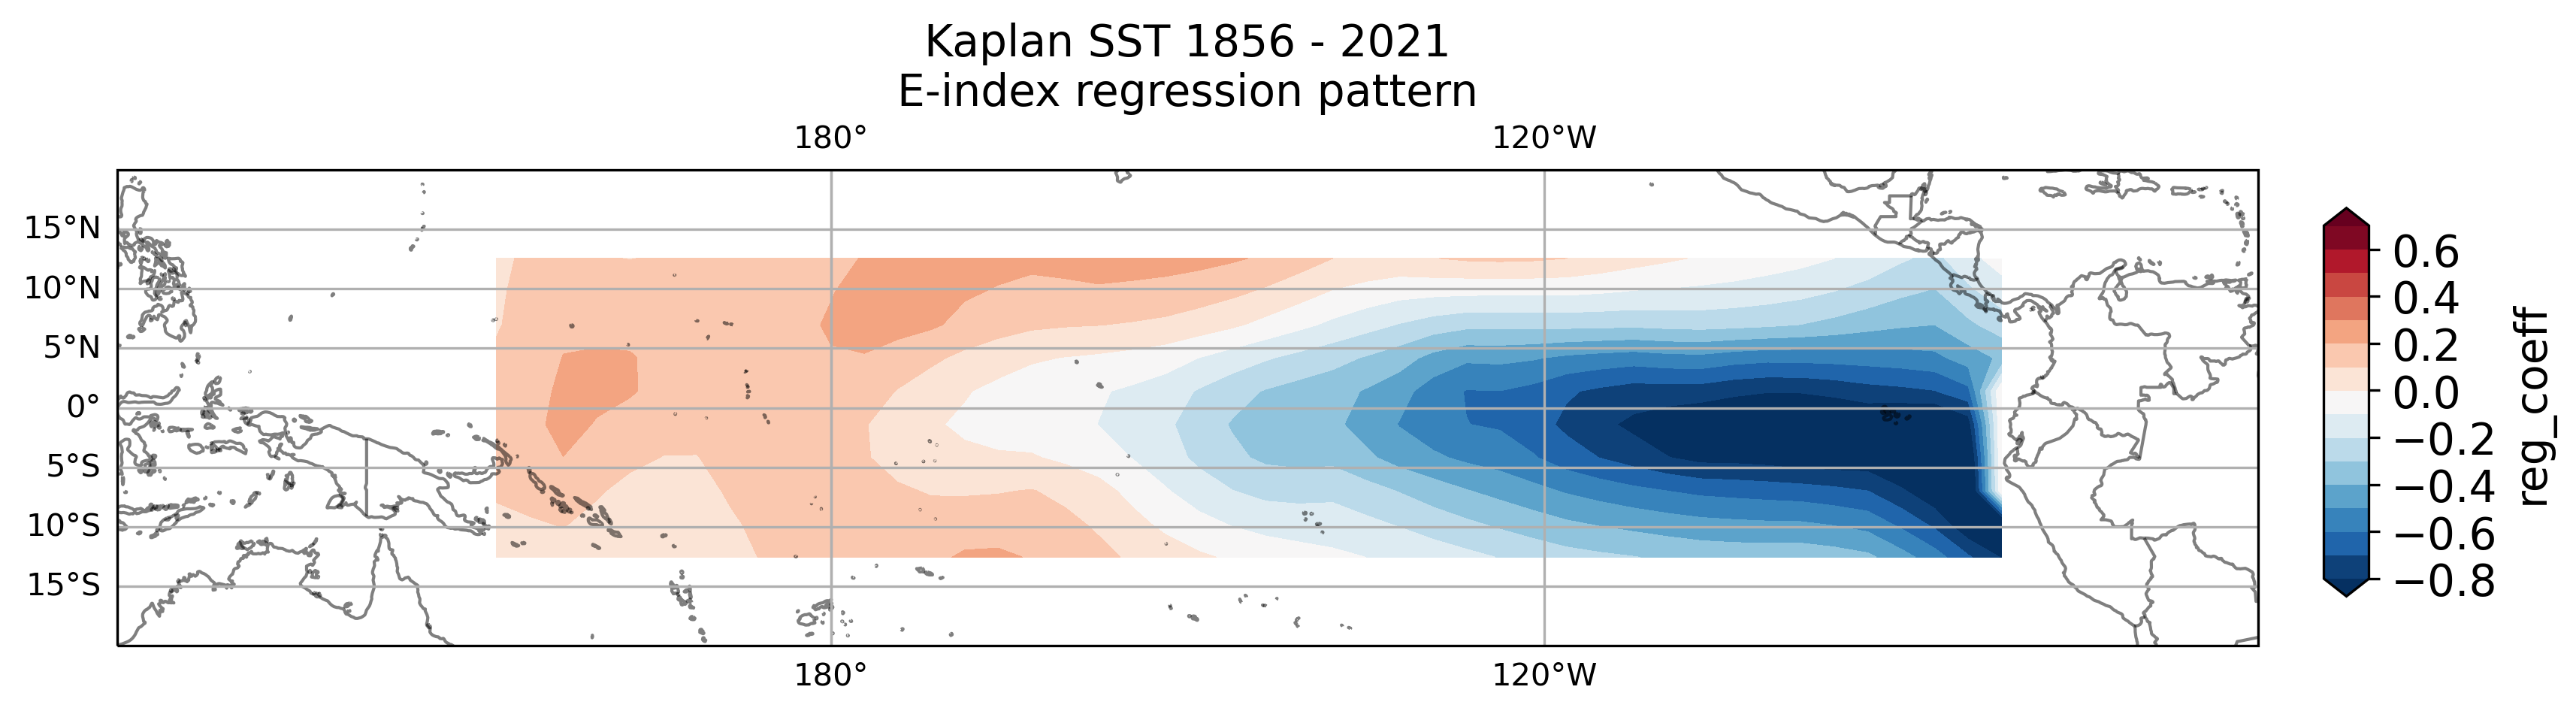

In [46]:
fig = plot_one_sst(patterns.eof2,'Kaplan SST 1856 - 2021 E-index regression pattern',patterns.eof2.lon,patterns.eof2.lat,[5,-5,180,220])

In [47]:
fig.savefig(path_out+'/plots/kaplan_'+time_out+'_E_index_regression_patterns.png')